# **Advance Lane Line Finding** 

***
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository. There is an writeup template in the repostitory provided as a starting point for your writeup of the project.

---
Steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply the distortion correction to the raw image.  
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). 
* Detect lane pixels and fit to find lane boundary.
* Determine curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
import ntpath
%matplotlib inline

# Utilies Functions

In [62]:
def camera_calibration():
    nx = 9 # of inner corners in x
    ny = 6 # of inner corners in y
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            directory = 'output_images/1_corners_found/'
            if not os.path.exists(directory):
                os.makedirs(directory)
            write_name = directory+'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist


# UNDISTORT 
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, None)
    return undist

# Gradient threshold 
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #print(scaled_sobel)
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Gradient threshold 
def hls_select(img, channel = 's', thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if 'h':
        channel = hls[:,:,0]
    if 'l':
        channel = hls[:,:,1]
    if 's':
        channel = hls[:,:,2]

    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

# color space and gradient tranform
def color_space_and_gradient(img, orient, grad_thresh, color_thresh):
    img = np.copy(img)
    grad_binary = abs_sobel_thresh(img, 'x', grad_thresh)    
    color_binary = hls_select(img, 's', color_thresh)
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    output = np.dstack(( np.zeros_like(grad_binary), grad_binary, color_binary))
    return grad_binary

def warp(image, src, dst):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = image
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

# Save Images:
def save_images(image, fname, directory, isBinary = 'false'):
    if not os.path.exists(directory):
        os.makedirs(directory)
        write_name = directory + fname +'.jpg'
        cv2.imwrite(write_name, image)

In [56]:
# Step 1: Camera Calibration
mtx, dist = camera_calibration()

In [91]:
# Build the pipline
def FindLaneLinesAdvanced(image, fname, mtx, dist, orient, grad_thresh, color_thresh, src, dst):
    undist = cal_undistort(image, mtx, dist)
    save_images(undist, fname, 'output_images/2_distortion_corrected/')    
    color_binary = color_space_and_gradient(undist,'x', grad_thresh, color_thresh)
    save_images(color_binary, fname, 'output_images/3_color_transforms/', 'true')
    birdseye = warp(color_binary, src, dst)
    histogram = np.sum(birdseye[birdseye.shape[0]/2:,:], axis=0) 

    #plot the images
    f, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=15)
    ax2.imshow(undist, cmap='gray')
    ax2.set_title('Undistorted', fontsize=15)
    ax3.imshow(color_binary, cmap='gray')
    ax3.set_title('Color Tranform', fontsize=15)
    ax4.imshow(birdseye, cmap='gray')
    ax4.set_title('Birdseye', fontsize=15)
    ax5.plot(histogram)
    ax5.set_title('Histogram', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return color_binary

/Users/sliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


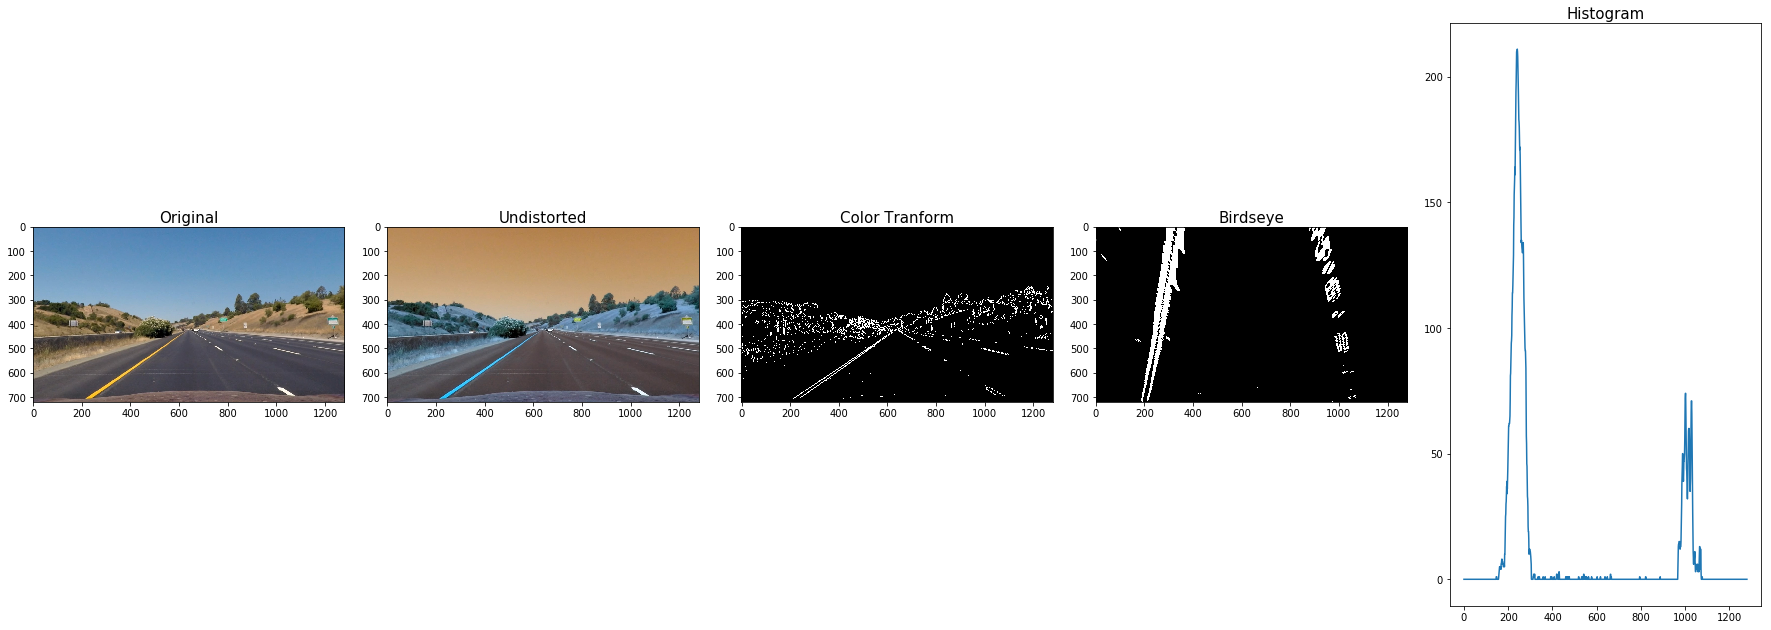

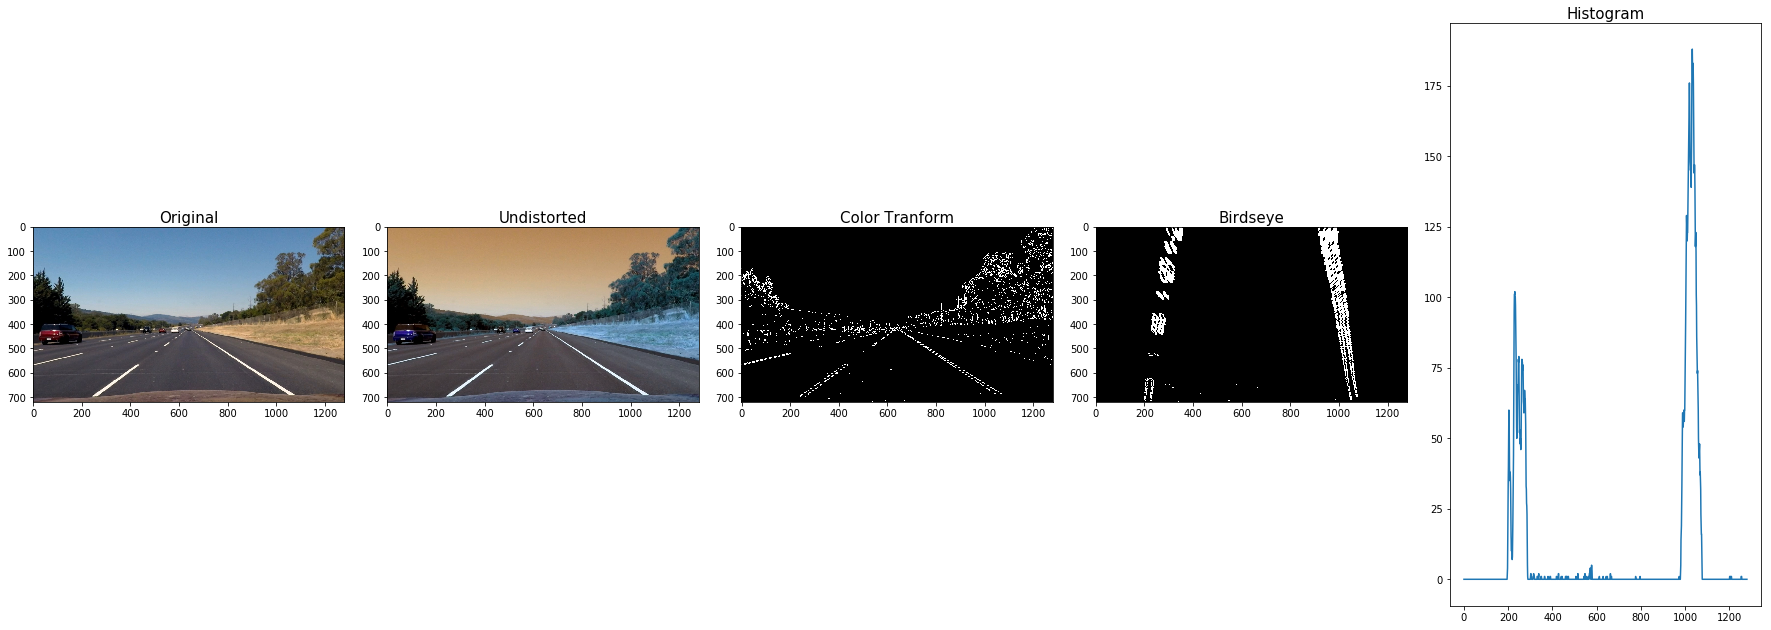

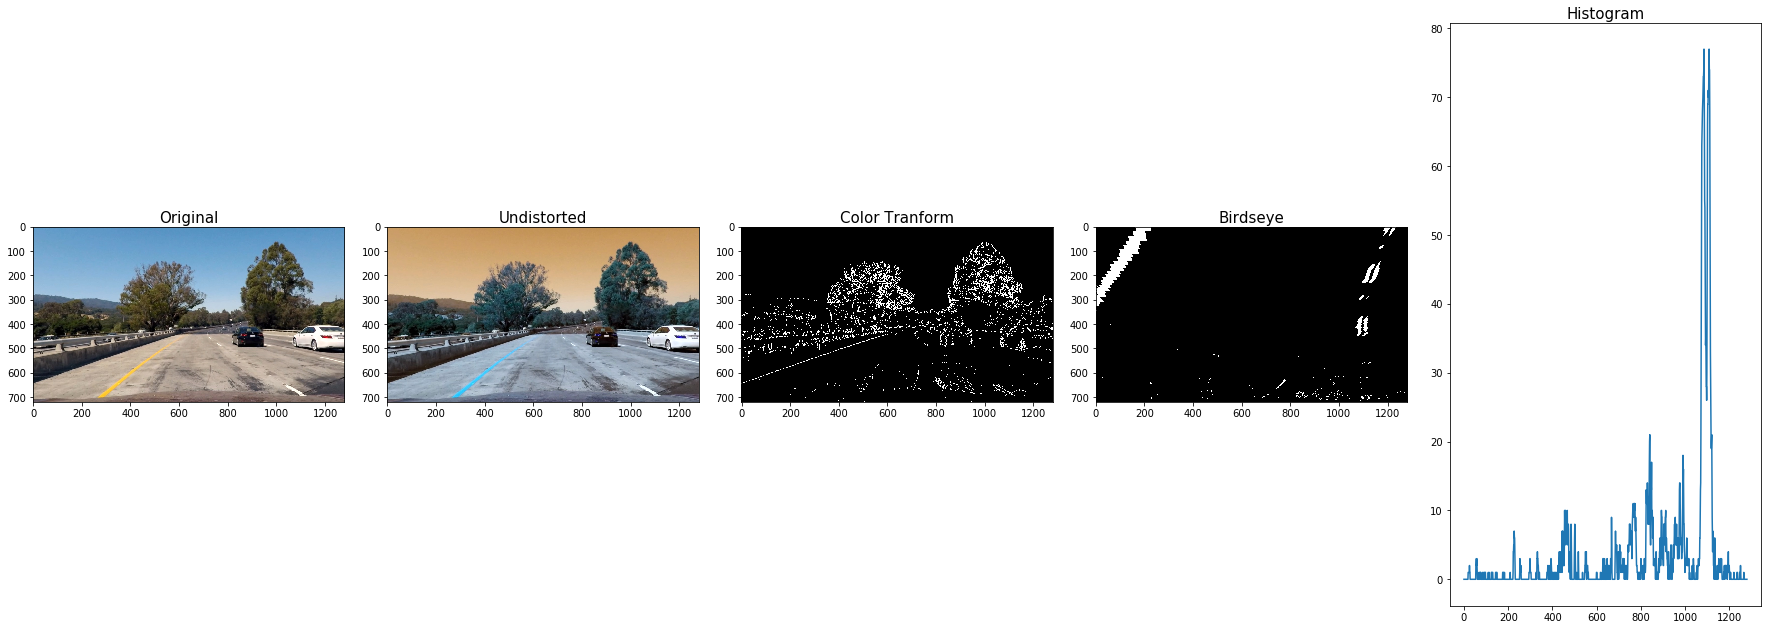

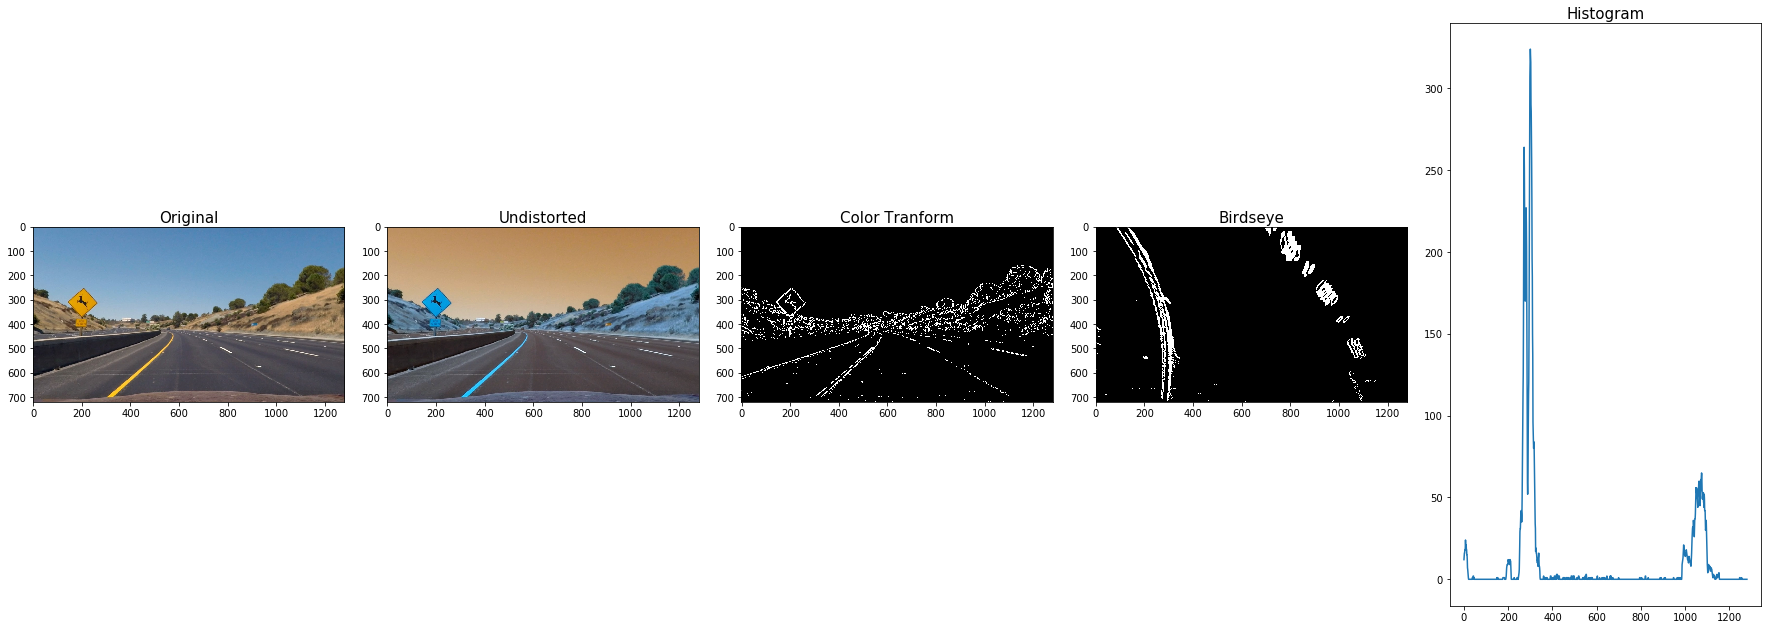

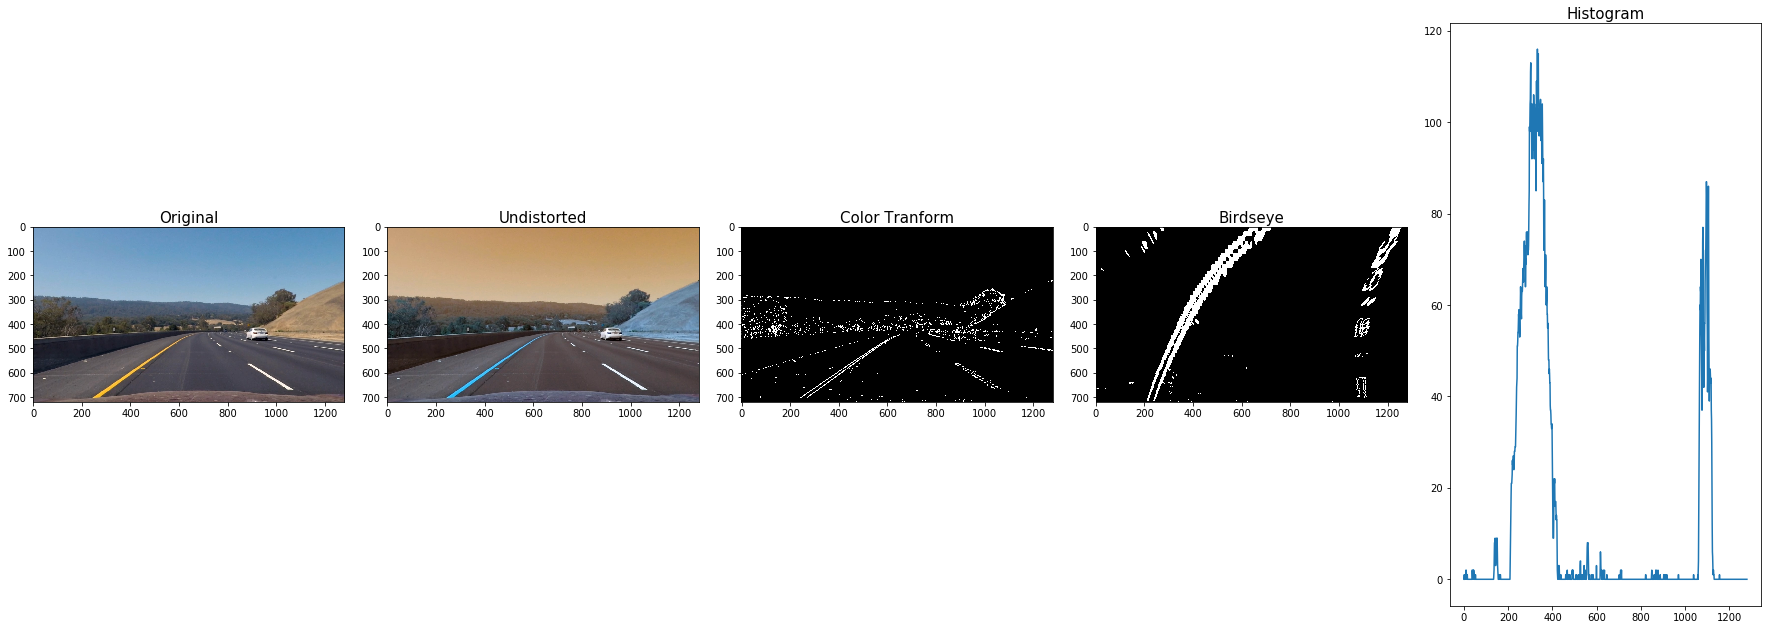

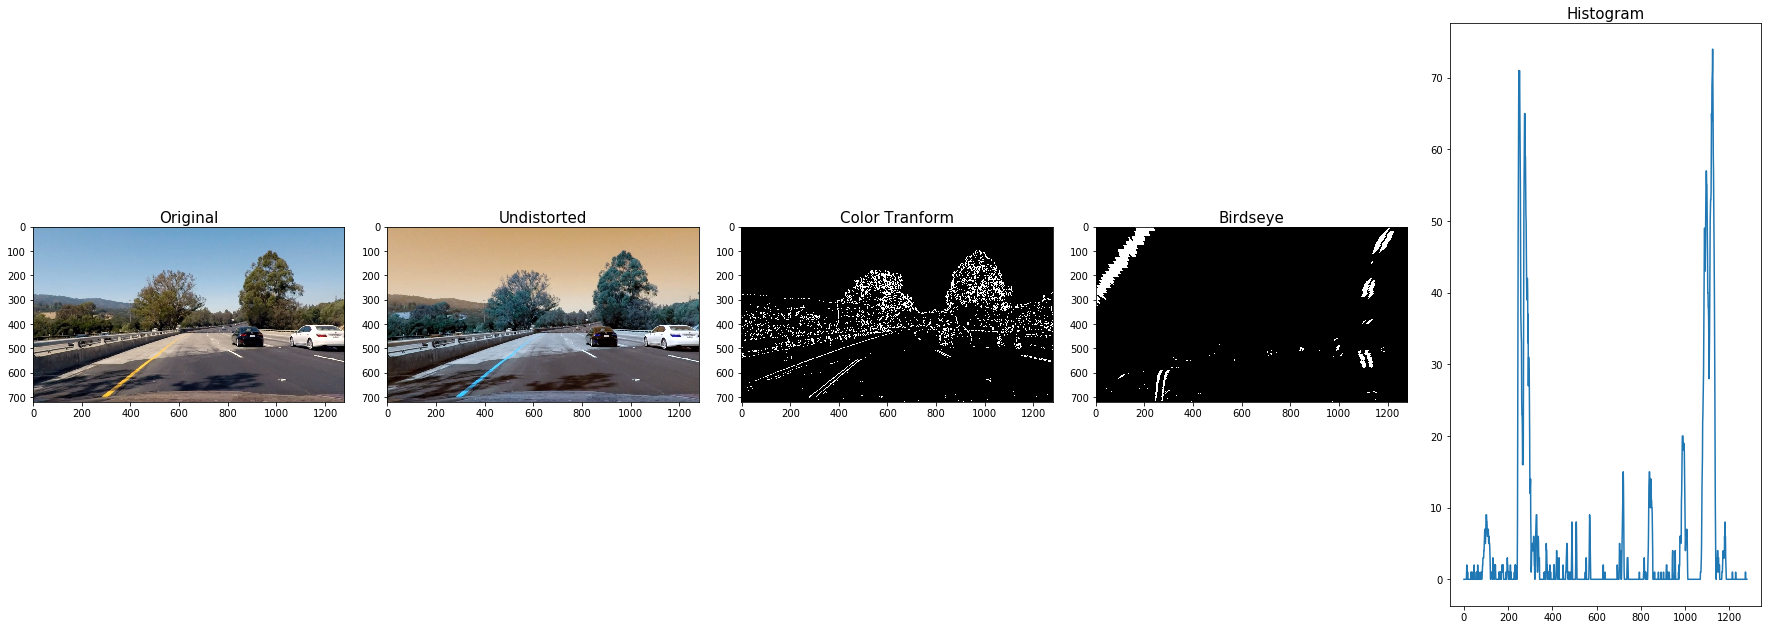

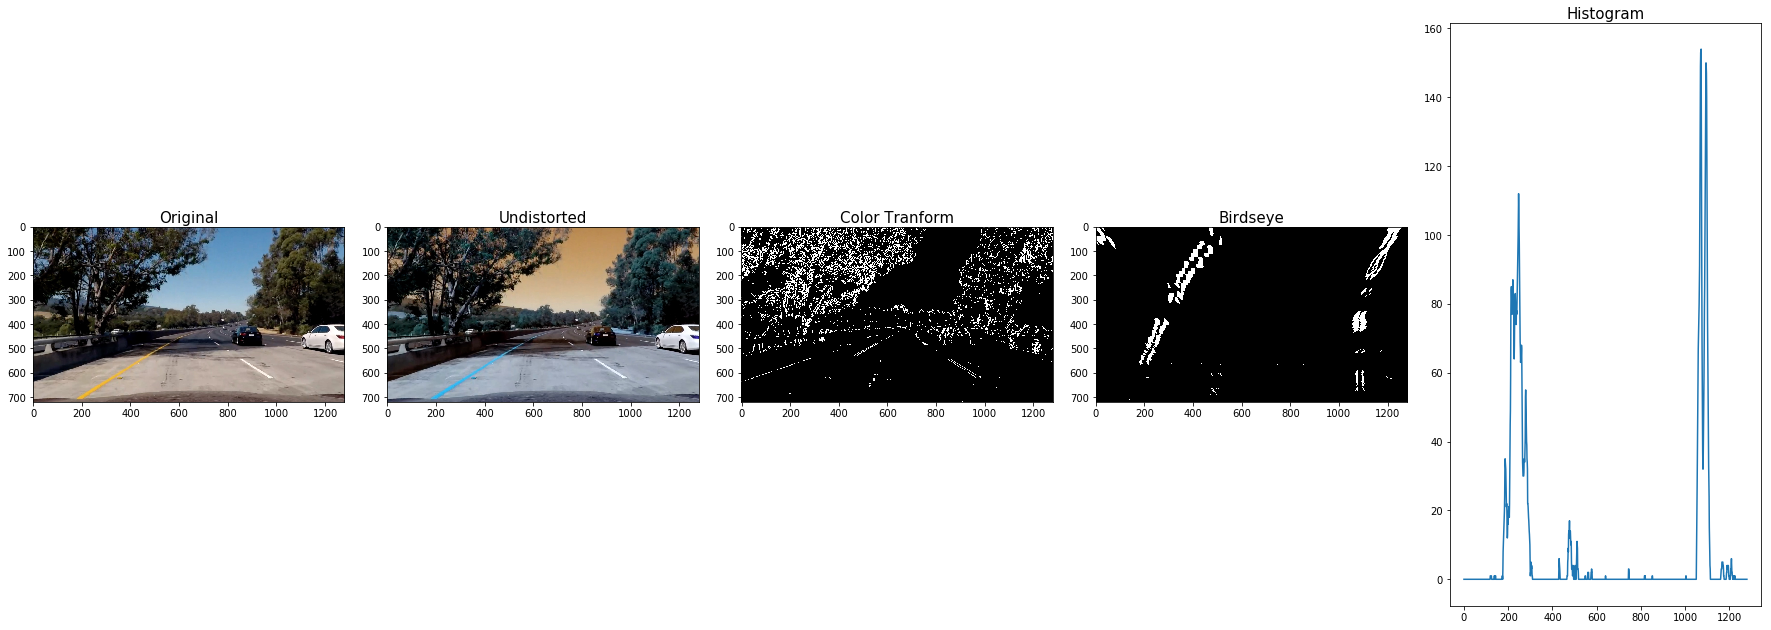

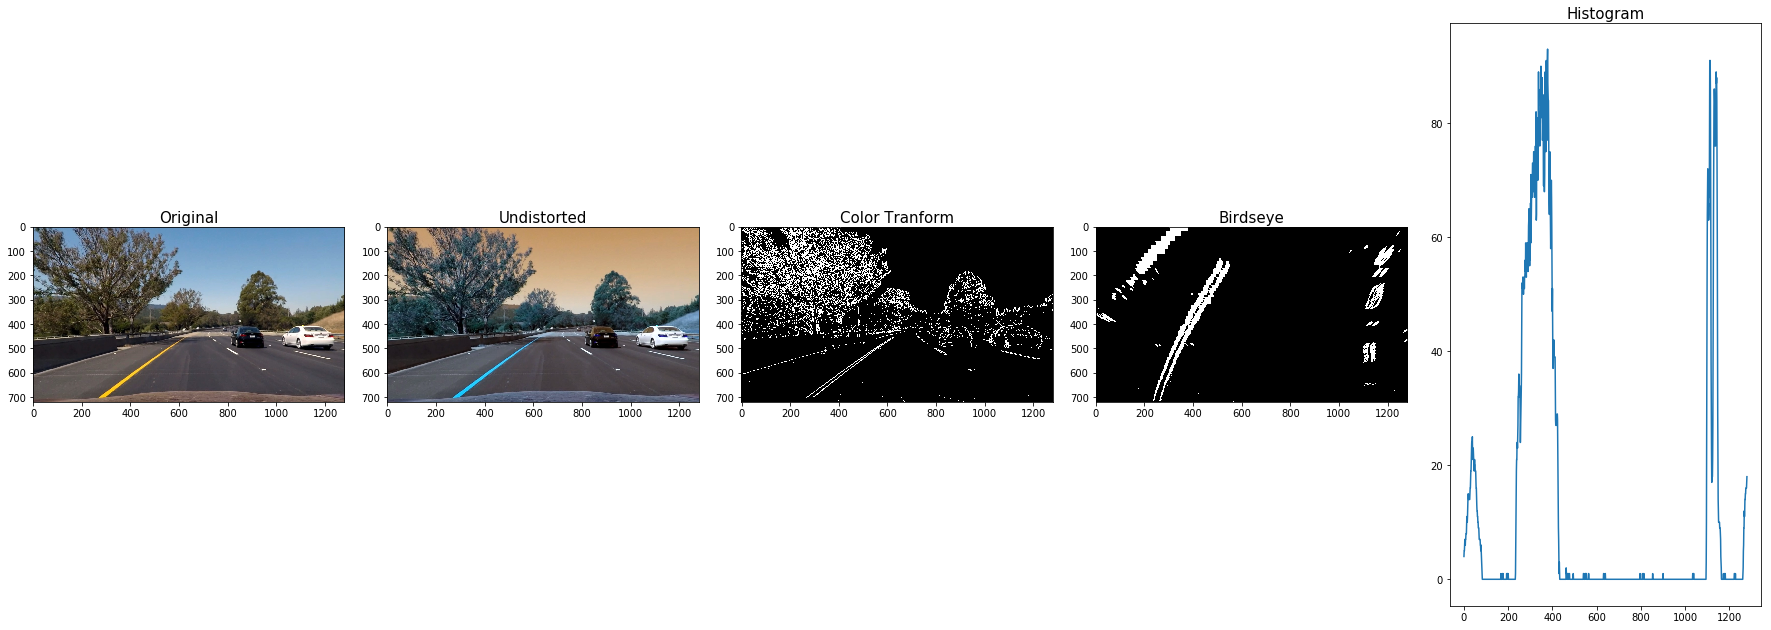

In [92]:
# Test with test images
for f in os.listdir("test_images/"):
    if not f.startswith('.'):
        image = cv2.imread('test_images/'+f)
        src = np.float32([(215, 715), (1120, 715), (606, 431), (676, 431)])
        dst = np.float32([(200, 720), (1080, 720), (200, -500), (1080, -500)])
        output = FindLaneLinesAdvanced(image, f, mtx, dist, 'x', \
                                         (20, 100), (125, 255), src, dst)
        #plt.imshow(output, cmap = 'gray') 

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`

`challenge_video.mp4`

`harder_challenge_video.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    imshape = image.shape
    #lines_edges = findLaneLines(image,5,50,150,\
                  #vertices,10, np.pi/180, 10, 35,20)
    output = image
    return output

In [ ]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
project_output